Import needed libraries

In [1]:
import cv2
import torch
from Encoders import TimeToFirstSpikeEncoding, GaussianEncoding
from matplotlib import pyplot as plt
from pymonntorch import *
import numpy as np
from timeRes import TimeResolution
from current import *
from lif import LIF, InputPattern
from synapse import *
from connections import Connections
from learning import *

In [2]:
# read an image and convert it to torch tensor
def image_to_vec(address, size=(10, 10)):
    img = cv2.imread(address)
    img = cv2.resize(img, (size[0], size[1]))
    img = torch.from_numpy(img)
    img = img.sum(2)//3

    return img


def show_image(img):
    plt.imshow(img, cmap='gray')  
    plt.show()


In [3]:
def raster_plot(spikes):
    
    plt.figure(figsize=(5,5))
    plt.xlim(0, len(spikes))
    s_spikes = torch.nonzero(spikes)
    plt.scatter(s_spikes[:,0], s_spikes[:,1], s=2, c='darkviolet')
    
        
    plt.xlabel("Time")
    plt.ylabel("Neurons")
    plt.show()

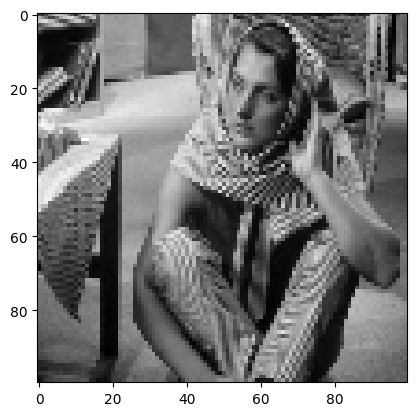

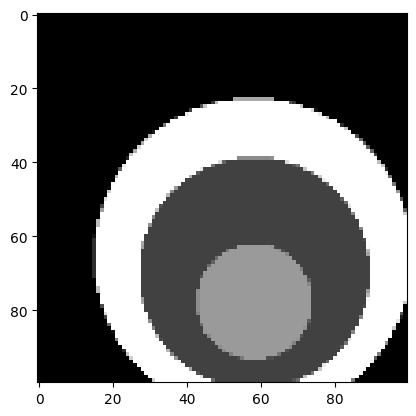

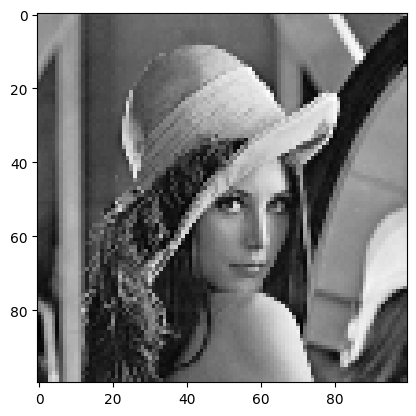

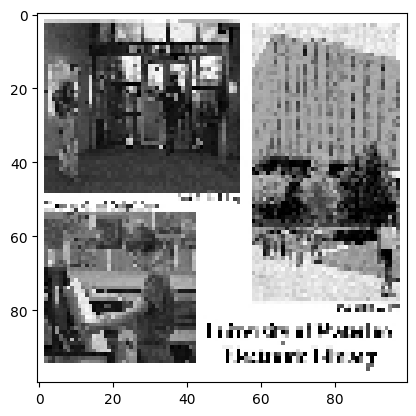

In [4]:
img1 = image_to_vec('images/barb.tif', (100, 100))
show_image(img1)
img2 = image_to_vec('images/circles.tif', (100, 100))
show_image(img2)
img3 = image_to_vec('images/lena1.tif', (100, 100))
show_image(img3)
img4 = image_to_vec('images/library.tif', (100, 100))
show_image(img4)


### Time To First Spike Encoding

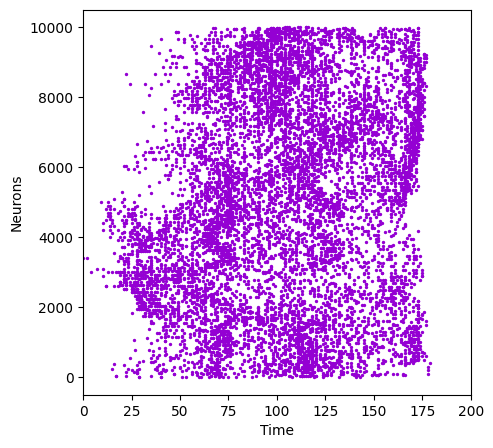

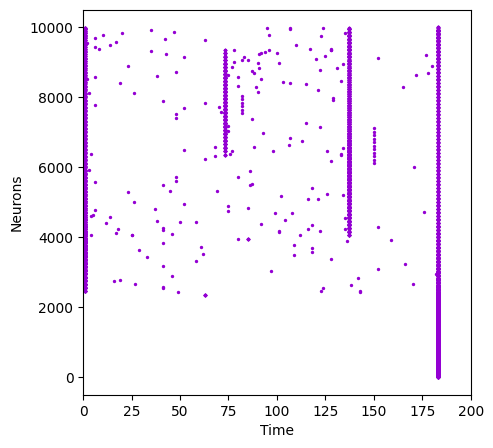

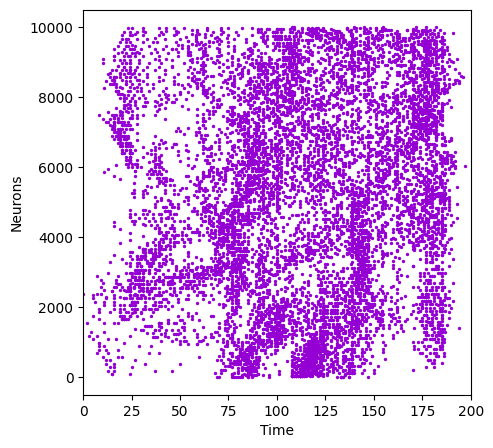

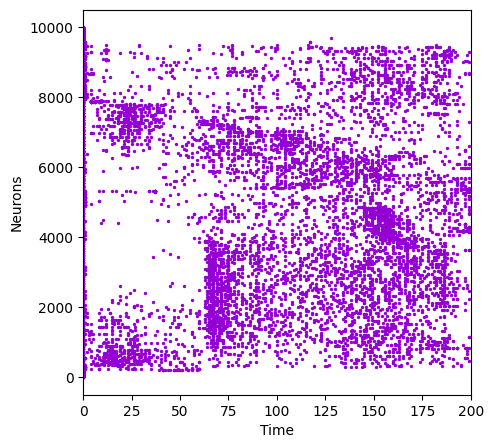

In [7]:
ttfs1 = TimeToFirstSpikeEncoding(img1, 200)
ttfs2 = TimeToFirstSpikeEncoding(img2, 200)
ttfs3 = TimeToFirstSpikeEncoding(img3, 200)
ttfs4 = TimeToFirstSpikeEncoding(img4, 200)

ttfs_spikes1 = ttfs1.encode()
ttfs_spikes2 = ttfs2.encode()
ttfs_spikes3 = ttfs3.encode()
ttfs_spikes4 = ttfs4.encode()

raster_plot(ttfs_spikes1)
raster_plot(ttfs_spikes2)
raster_plot(ttfs_spikes3)
raster_plot(ttfs_spikes4)

### Gaussian Encoding

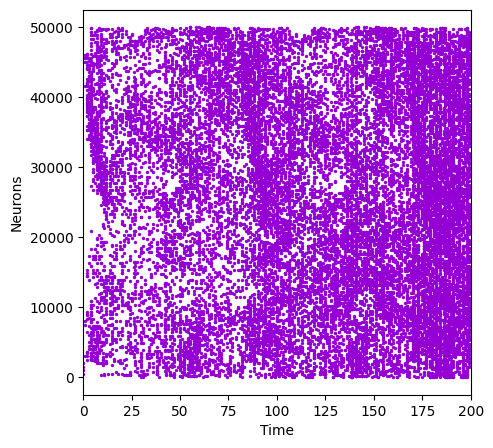

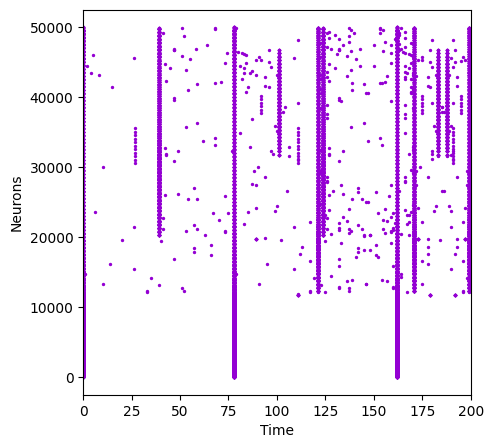

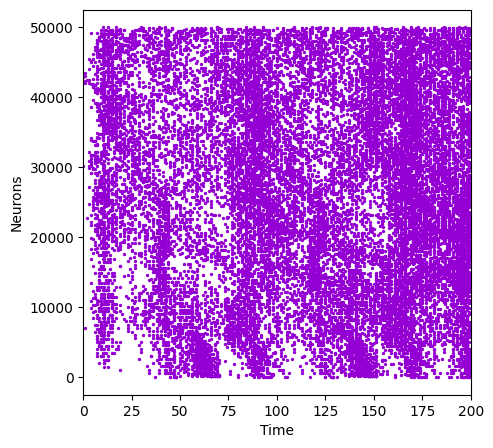

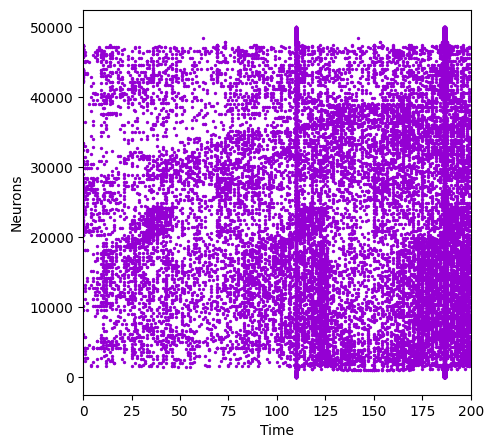

In [5]:
ge1 = GaussianEncoding(img1, 200, 5)
ge2 = GaussianEncoding(img2, 200, 5)
ge3 = GaussianEncoding(img3, 200, 5)
ge4 = GaussianEncoding(img4, 200, 5)

ge_spikes1 = ge1.encode()
ge_spikes2 = ge2.encode()
ge_spikes3 = ge3.encode()
ge_spikes4 = ge4.encode()

raster_plot(ge_spikes1)
raster_plot(ge_spikes2)
raster_plot(ge_spikes3)
raster_plot(ge_spikes4)

In [ ]:

# ge1 = PoissonEncoder(img1, 100)
# spikes1 = ge1.encode()
# ge2 = PoissonEncoder(img2, 100)
# spikes2 = ge2.encode()


In [5]:
def fill_pattern(pattern, n_free, is_right=True):
    pattern = pattern.transpose(-2, 1)
    shape = pattern.shape
    new_pattern = torch.zeros(shape[0]+n_free, shape[1])
    if is_right:
        for i in range(pattern.shape[0]):
            for j in range(pattern.shape[1]):
                new_pattern[i][j] = pattern[i][j] 
    else:
        for i in range(pattern.shape[0]):
            for j in range(pattern.shape[1]):
                new_pattern[i+n_free][j] = pattern[i][j]

    return new_pattern


In [6]:
pattern1 = fill_pattern(spikes1, 0)
pattern2 = fill_pattern(spikes2, 0, False)

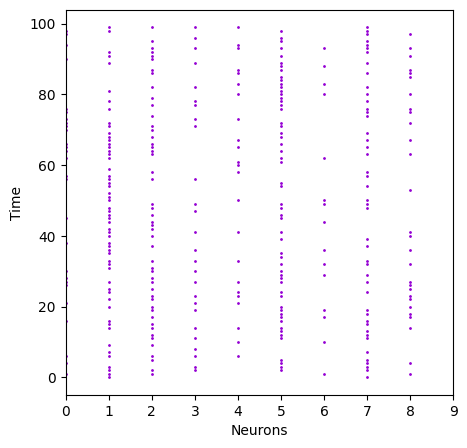

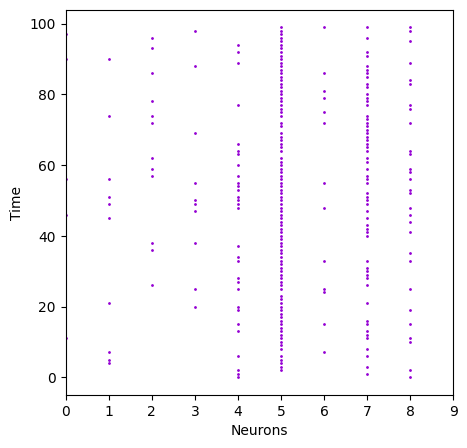

In [7]:
# spikes1 = spikes1.transpose(-2, 1)
raster(pattern1)
# spikes2 = spikes2.transpose(-2, 1)
raster(pattern2)

In [8]:
pattern1 = pattern1.transpose(-2, 1)
pattern2 = pattern2.transpose(-2, 1)

In [26]:

net = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
input_ng = NeuronGroup(
    9,
    net=net,
    behavior={
        7: InputPattern(pattern=pattern1, pattern2=pattern2, cpt=40, sleep=20),
    },
    tag="inp_NG1",
)


output_ng = NeuronGroup(
    2,
    net=net,
    behavior={
        2: ConstantCurrent(value=0),
        5: InpSyn(),
        7: LIF(
            tau=20,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-35,
            R=5,
            N=2,
        ),
        9: Recorder(variables=["v", "I"], tag="inh_ng1_rec, inh_ng1_recorder"),
        10: EventRecorder("spike", tag="inh_ng1_evrec"),
    },
    tag="out_NG2",
)

connect_inp_out = SynapseGroup(net=net,
                src=input_ng, 
                dst=output_ng, 
                behavior={
                    3: SynFun(),
                    4: RSTDP(),
                    5: Connections(def_val=20, type="full"),    
                    11: Recorder(variables=["W"], tag="layers weights"),  
                })


In [15]:
indexesi = [random.randint(0, 150) for _ in range(20)]
indexesj = [random.randint(0, 100) for _ in range(20)]

k = 0
for i in range(20):
    if pattern1[indexesi[k]][indexesj[k]]:
        pattern1[indexesi[k]][indexesj[k]] = False
    else:
        pattern1[indexesi[k]][indexesj[k]] = True
    k += 1
        

In [18]:
net = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
input_ng = NeuronGroup(
    100,
    net=net,
    behavior={
        7: InputPattern(pattern=pattern1, pattern2=pattern2, cpt=200, sleep=50),
    },
    tag="inp_NG1",
)


output_ng = NeuronGroup(
    3,
    net=net,
    behavior={
        2: ConstantCurrent(value=10),
        5: InpSyn(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-35,
            R=5,
            N=2,
        ),
        9: Recorder(variables=["v", "I"], tag="inh_ng1_rec, inh_ng1_recorder"),
        10: EventRecorder("spike", tag="inh_ng1_evrec"),
    },
    tag="out_NG2",
)

connect_inp_out = SynapseGroup(net=net,
                src=input_ng, 
                dst=output_ng, 
                behavior={
                    3: SynFun(),
                    4: STDP(),
                    5: Connections(def_val=20, type="full"),    
                    11: Recorder(variables=["W"], tag="layers weights"),  
                })


In [27]:
net.initialize()
net.simulate_iterations(100)

Network['Network_1', 'Network'](Neurons: tensor(11)|2 groups, Synapses: tensor(18)|1 groups){1:TimeResolution()}
NeuronGroup['inp_NG1', 'NeuronGroup', 'ng'](9){7:InputPattern(pattern=tensor([[0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [1., 1., 1., 0., 0., 0., 1., 0., 1.],
        [0., 1., 1., 1., 0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 0., 1., 1.],
        [0., 0., 1., 0., 0., 1., 0., 1., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 1., 1., 1., 1., 1., 0., 0., 1.],
        [0., 1., 1., 0., 0., 0., 0., 1., 0.],
        [1., 1., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1., 1.

1821.2871551513672

In [28]:
net1 = net["W", 0][40]
column1 = []  # First column
column2 = []  # First column
for i in range(net1.shape[0]):
    column1.append(net1[i][0].item())
    column2.append(net1[i][1].item())
# column2 = matrix[:, 1]  # Second column
print(column1, column2)
# Calculate dot product
dot_product = np.dot(column1, column2)
print(dot_product)
# Calculate magnitudes
magnitude1 = np.linalg.norm(column1)
magnitude2 = np.linalg.norm(column2)
print(magnitude1, magnitude2)
# Calculate cosine similarity
cosine_similarity = dot_product / (magnitude1 * magnitude2)
print(cosine_similarity)

[17.43877786397934, 10.0, 10.0, 19.105698585510254, 19.587909698486328, 10.0, 14.521433770656586, 10.0, 25.53543996810913] [10.0, 10.0, 10.0, 10.0, 10.024906158447266, 10.0, 10.0, 10.0, 10.0]
1362.3804584500176
48.122298691003 30.00831124014935
0.9434317453165031


tensor([[22.8002, 28.3309],
        [30.0000, 30.0000],
        [29.5672, 30.0000],
        [17.5270, 24.9680],
        [30.0000, 30.0000],
        [30.0000, 30.0000],
        [19.1976, 22.7431],
        [30.0000, 30.0000],
        [22.2981, 30.0000]], dtype=torch.float64)


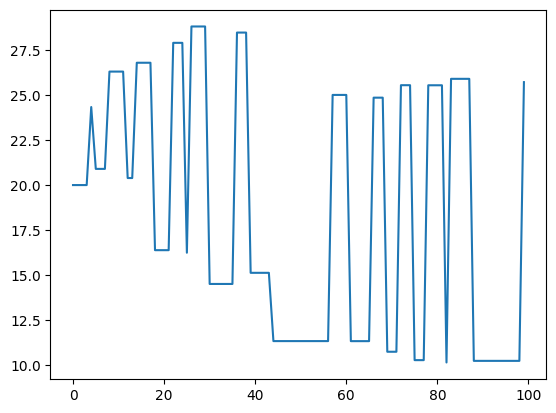

In [31]:
print(net["W", 0][-1])
vars1 = []
vars2 = []

for i in range(100):
    sum1 = 0
    sum2 = 0
    for j in range(9):
        sum1 += net["W", 0][i][j][1]
        sum2 += net["W", 0][i][j][0]
    vars1.append(sum1/9)
    vars2.append(sum2/9)

time = [i for i in range(100)]
# plt.plot(time, vars1)
plt.plot(time, vars2)
# # plt.plot(vars2, label="exc2")
# # plt.plot(vars3, label="inh")
# plt.xlabel("time")
# plt.ylabel("v")
# plt.legend()
# plt.show()